# Setup

In [5]:
!pip install --quiet gradio==3.44.4 transformers[sentencepiece] git+https://github.com/huggingface/peft.git typing_extensions==4.7.1 scipy datasets evaluate sacrebleu cchardet

In [6]:
import torch
import gc

# Function to clear GPU memory
def clear_gpu_memory():
    # Delete model and tensors if they are defined
    global model, inputs, input_ids
    if 'model' in globals():
        del model
    if 'inputs' in globals():
        del inputs
    if 'input_ids' in globals():
        del input_ids

    # Clear PyTorch cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Force Python's garbage collector to run
    gc.collect()

# Call the function to clear GPU memory
clear_gpu_memory()

In [34]:
import os
import sys

import transformers
from peft import PeftModel
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer

import evaluate
from datasets import load_dataset


"""
Helpers to support streaming generate output.
Borrowed from https://github.com/oobabooga/text-generation-webui/blob/ad37f396fc8bcbab90e11ecf17c56c97bfbd4a9c/modules/callbacks.py
"""

import gc
import traceback
from queue import Queue
from threading import Thread

import torch
import transformers

class Stream(transformers.StoppingCriteria):
    def __init__(self, callback_func=None):
        self.callback_func = callback_func

    def __call__(self, input_ids, scores) -> bool:
        if self.callback_func is not None:
            self.callback_func(input_ids[0])
        return False

class Iteratorize:
    """
    Transforms a function that takes a callback
    into a lazy iterator (generator).
    """

    def __init__(self, func, kwargs={}, callback=None):
        self.mfunc = func
        self.c_callback = callback
        self.q = Queue()
        self.sentinel = object()
        self.kwargs = kwargs
        self.stop_now = False

        def _callback(val):
            if self.stop_now:
                raise ValueError
            self.q.put(val)

        def gentask():
            try:
                ret = self.mfunc(callback=_callback, **self.kwargs)
            except ValueError:
                pass
            except:
                traceback.print_exc()
                pass

            self.q.put(self.sentinel)
            if self.c_callback:
                self.c_callback(ret)

        self.thread = Thread(target=gentask)
        self.thread.start()

    def __iter__(self):
        return self

    def __next__(self):
        obj = self.q.get(True, None)
        if obj is self.sentinel:
            raise StopIteration
        else:
            return obj

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.stop_now = True

"""
A dedicated helper to manage templates and prompt building.
"""

import json
import os.path as osp
from typing import Union


class Prompter(object):
    __slots__ = ("template", "_verbose")

    def __init__(self, template_name: str = "", verbose: bool = False):
        self._verbose = verbose
        template_name = "alpaca"
        self.template = {
            "description": "Template used by Alpaca-LoRA.",
            "prompt_input": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n",
            "prompt_no_input": "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n",
            "response_split": "### Response:"
        }
        if self._verbose:
            print(
                f"Using prompt template {template_name}: {self.template['description']}"
            )

    def generate_prompt(
        self,
        instruction: str,
        input: Union[None, str] = None,
        label: Union[None, str] = None,
    ) -> str:
        # returns the full prompt from instruction and optional input
        # if a label (=response, =output) is provided, it's also appended.
        if input:
            res = self.template["prompt_input"].format(
                instruction=instruction, input=input
            )
        else:
            res = self.template["prompt_no_input"].format(
                instruction=instruction
            )
        if label:
            res = f"{res}{label}"
        if self._verbose:
            print(res)
        return res

    def get_response(self, output: str) -> str:
        return output.split(self.template["response_split"])[1].strip()


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

try:
    if torch.backends.mps.is_available():
        device = "mps"
except:  # noqa: E722
    pass

#! Check the number of available GPUs and prepare a device map
num_gpus = torch.cuda.device_count()
device_map = {i: f'cuda:{i}' for i in range(num_gpus)}


base_model = 'openthaigpt/openthaigpt-1.0.0-beta-7b-chat-ckpt-hf'
lora_weights = None
# lora_weights = './openthaigpt-finetune/synthetic_v2'
load_8bit = False
prompt_template = ""
server_name = "0.0.0.0"
share_gradio = True

prompter = Prompter(prompt_template)
tokenizer = LlamaTokenizer.from_pretrained(base_model)
if device == "cuda":
    print("DEVICEEEEE CUDAAAAA",device_map)
    model = LlamaForCausalLM.from_pretrained(
        base_model,
        load_in_8bit=load_8bit,
        torch_dtype=torch.float16,
        # device_map=device_map,
        device_map="auto",
    )
    if lora_weights:
        print("using lora_weights: ", lora_weights)
        model = PeftModel.from_pretrained(
          model,
          lora_weights,
          torch_dtype=torch.float16,
      )
elif device == "mps":
    model = LlamaForCausalLM.from_pretrained(
        base_model,
        device_map={"": device},
        torch_dtype=torch.float16,
    )
    if lora_weights:
      model = PeftModel.from_pretrained(
          model,
          lora_weights,
          device_map={"": device},
          torch_dtype=torch.float16,
      )
else:
    model = LlamaForCausalLM.from_pretrained(
        base_model, device_map={"": device}, low_cpu_mem_usage=True
    )
    if lora_weights:
      model = PeftModel.from_pretrained(
          model,
          lora_weights,
          device_map={"": device},
      )

# unwind broken decapoda-research config
model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
model.config.bos_token_id = 1
model.config.eos_token_id = 2

# if not load_8bit:
#     model.half()  # seems to fix bugs for some users.

model.eval()
if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)
print("MODEL READY LA")

DEVICEEEEE CUDAAAAA {0: 'cuda:0', 1: 'cuda:1', 2: 'cuda:2', 3: 'cuda:3'}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MODEL READY LA


# Evaluate by calling a function

Streaming yield better result, 

## Init Evaluation Function

In [17]:
def text_evaluate(
        instruction,
        input=None,
        temperature=0.85,
        top_p=0.65,
        top_k=30,
        num_beams=4,
        max_new_tokens=2048,
        # stream_output=False,
        stream_output=True,
        repetition_penalty=1.2,
        no_repeat_ngram=2,
        **kwargs,
    ):
    prompt = prompter.generate_prompt(instruction, input)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        do_sample=True,
        **kwargs,
    )
    generate_params = {
        "input_ids": input_ids,
        "generation_config": generation_config,
        "return_dict_in_generate": True,
        "output_scores": True,
        "max_new_tokens": max_new_tokens,
        "early_stopping": True,
        "repetition_penalty":repetition_penalty,
        "no_repeat_ngram_size":no_repeat_ngram
    }
    if stream_output:
        # Stream the reply 1 token at a time.
        # This is based on the trick of using 'stopping_criteria' to create an iterator,
        # from https://github.com/oobabooga/text-generation-webui/blob/ad37f396fc8bcbab90e11ecf17c56c97bfbd4a9c/modules/text_generation.py#L216-L243.

        def generate_with_callback(callback=None, **kwargs):
            kwargs.setdefault(
                "stopping_criteria", transformers.StoppingCriteriaList()
            )
            kwargs["stopping_criteria"].append(
                Stream(callback_func=callback)
            )
            with torch.no_grad():
                model.generate(**kwargs)

        def generate_with_streaming(**kwargs):
            return Iteratorize(
                generate_with_callback, kwargs, callback=None
            )

        with generate_with_streaming(**generate_params) as generator:
            temp = []
            for output in generator:
                # new_tokens = len(output) - len(input_ids[0])
                decoded_output = tokenizer.decode(output)

                if output[-1] in [tokenizer.eos_token_id]:
                    break
                temp.append(decoded_output)

                
        return  temp[-1]# early return for stream_output

    # Without streaming
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    return tokenizer.decode(s).split("### Response:")[1].strip()

## Prompting and Running

### Translation English to Thai

In [15]:
instruction = "แปลอังกฤษเป็นภาษาไทย"
print("#Instruction:", instruction, "\n")
for input in [
    "Why is the sky so blue today?",
    "Why is the sky so blue today? wow",
    ""
    
]:
    def prompt(input="hello", instruction="แปลภาษาไทยเป็นอังกฤษ", prnout=False):
        out = text_evaluate(instruction=instruction, 
                                         input=input,                                         
                                        )
        if prnout:
            for i in out.split("###")[-2:]:
                print("##" ,i.strip())
                print()
            print("---------------------------------------------------")
        return out
    prompt(input,  prnout=True)

#Instruction: แปลอังกฤษเป็นภาษาไทย 

## Input:
Why is the sky so blue today?

## Response:
วันนี้ฟ้าสีสวยมากมั้ย?

---------------------------------------------------
## Input:
Why is the sky so blue today? wow

## Response:
วันนี้ฟ้าสีสวยมากอ่ะ ว้าว

---------------------------------------------------
## Instruction:
แปลภาษาไทยเป็นอังกฤษ

## Response:
ฉันชอบหนังสือชุดนี้มาก แต่หนังสือเล่มนี้แย่มาก ฉันไม่สามารถอ่านต่อไปได้อีกแล้ว :( ขอโทษด้วยค่ะ

---------------------------------------------------


### Eval

In [12]:
import random
import evaluate
import csv

def read_csv_to_list(file_path):
    data_list = []
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            data_list.append(row)
    return data_list



def compute_chrf(reference, hypothesis):
    # Initialize the chrF++ metric
    chrf_metric = evaluate.load("chrf")

    # Compute the score
    results = chrf_metric.compute(predictions=[hypothesis], references=[reference])

    return results

list_csv = read_csv_to_list("out_synthetic_pairs2.csv")
random.shuffle(list_csv)


In [35]:
s_list = []
stats_list = []
for i, line in enumerate(list_csv):
    if i == 100:
        break
    # print(line.split(","))
    try:

        ref_en =  line[0].strip()
        ref_th =  line[1].strip()
        out = prompt(ref_en,  prnout=False)
        out_th = out.split("###")[-1].split(":")[-1]
        print("ref_th ", ref_th.strip())
        print("out_th ", out_th.strip())
        score = compute_chrf(ref_th.strip(), out_th.strip())
        s_list.append(score['score'])
        print("chrF++ Score:  ", score)
        print()
        stats_list.append(score)
    except:
        pass


def Average(lst): 
    return sum(lst) / len(lst) 


average = Average(s_list) 
 
# Printing average of the list 
print("Average chrF++ Score =", round(average, 2)) 


    

ref_th  สมาคมประมงสงขลาเตือนเรือประมงและเรือพาณิชย์ว่าต้องใช้ความระมัดระวังในการเดินเรือหลังมีหมอกลงจัดในทะเลและทัศนวิสัยลดลง ขอให้ตรวจสอบสปอร์ตไลท์เป็นเครื่องส่องทางและไฟสัญญาณเรือเพื่อป้องกันไม่ให้เกิดเหตุอุบัติเหตุการชนเรือกัน
out_th  สมาคมประมงจังหวัดสงขลาแนะนำให้เรือประมงและเรือขนส่งสินค้าเพิ่มความระมัดระวังในน่านทะเลเนื่องจากหมอกที่ทวีความรุนแรงขึ้น และเรือต้องตรวจสอบสัญญาณไฟและไฟเรือ เพื่อป้องกันอุบัติเหตุ
chrF++ Score:   {'score': 43.06115839819153, 'char_order': 6, 'word_order': 0, 'beta': 2}

ref_th  ปัจจุบันค่ายเอเอเอสออโต้เซอร์วิสเป็นที่เชื่อถือได้ในการนำเข้าและจัดจำหน่ายรถยนต์ 2 แบรนด์หรู ที่เป็นทางการเท่านั้นในประเทศไทย คือ ปอร์เช่ และเบนท์ลีย์
out_th  บริษัท เอเอสออโต้เซอร์วิส จำกัด เป็นผู้นําเข้าอย่างเป็นทางการและจําหน่ายรถยนต์ปอร์เช่และบีเอ็มดับเบิลยูแบรนด์ชั้น
chrF++ Score:   {'score': 39.89326667768569, 'char_order': 6, 'word_order': 0, 'beta': 2}

ref_th  เจ้าหน้าที่กู้ภัยอินโดนีเซียนำร่าง 3 นักศึกษา ที่ติดอยู่ภายในถ้ำเลเล (Lele) เมืองการาวัง จังหวัดชวาตะวันตก หลังฝ

In [36]:
# weighted_model = stats_list.copy()
base_model_stats = stats_list.copy()

In [37]:
# weighted_model

# weighted_scores = []
# for i in weighted_model:
#     weighted_scores.append(i["score"])
# weighted_scores

base_scores = []
for i in base_model_stats:
    base_scores.append(i["score"])
base_scores


[43.06115839819153,
 39.89326667768569,
 41.477718191335896,
 41.38713766434846,
 33.58853333362549,
 36.33345344779065,
 37.52502452761783,
 19.38439677860608,
 22.08406347556885,
 18.139066052802644,
 26.849776674820653,
 22.41355861522041,
 27.566816047613287,
 27.048041803280814,
 27.91949185484884,
 37.60453893784798,
 57.37583607136981,
 28.334550522854745,
 30.00896073358491,
 20.604050601802324,
 28.810929454800515,
 26.260942222290513,
 39.43743876005885,
 40.630460353536726,
 32.42200197308408,
 31.21767198828091,
 41.55160342420165,
 20.718662958485105,
 30.72296423626134,
 28.563767741361186,
 36.42201466021731,
 39.44656921551782,
 20.037476945214056,
 25.084421150265797,
 39.454150681195486,
 34.34217229557522,
 27.060812552784625,
 22.06934894131418,
 48.13693908792135,
 23.769725226464303,
 18.83810650099371,
 46.62667846632125,
 16.132792841374943,
 51.58417503514513,
 27.61433952809913,
 40.531307741982495,
 42.06265325133292,
 38.516614169532296,
 30.785149043360693,

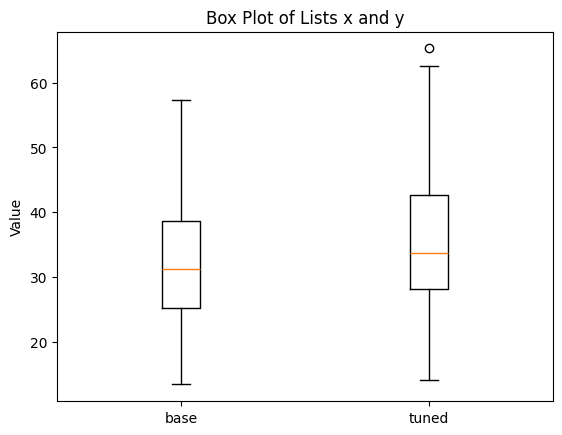

In [39]:
import matplotlib.pyplot as plt
#base
x = base_scores
y = weighted_scores

data = [x, y]

plt.boxplot(data)
plt.xticks([1, 2], ['base', 'tuned'])

plt.title('Box Plot of Lists x and y')
plt.ylabel('Value')

plt.show()


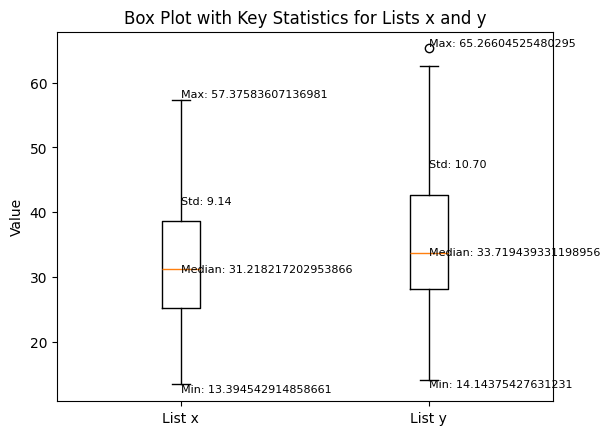

In [45]:
import matplotlib.pyplot as plt
import numpy as np

x = base_scores
y = weighted_scores
data = [x, y]

# Create box plot
plt.boxplot(data)
plt.xticks([1, 2], ['List x', 'List y'])

# Function to annotate key statistics
def annotate_stats(data, xpos):
    max_val = np.max(data)
    min_val = np.min(data)
    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data)

    plt.text(xpos, max_val, f'Max: {max_val}', ha='left', va='bottom', fontsize=8)
    plt.text(xpos, min_val, f'Min: {min_val}', ha='left', va='top', fontsize=8)
    # plt.text(xpos, mean_val, f'Mean: {mean_val:.2f}', ha='left', va='center', fontsize=8)
    plt.text(xpos, median_val, f'Median: {median_val}', ha='left', va='center', fontsize=8)
    plt.text(xpos, mean_val + std_val, f'Std: {std_val:.2f}', ha='left', va='bottom', fontsize=8)

# Annotate stats for each list
annotate_stats(x, 1)
annotate_stats(y, 2)

plt.title('Box Plot with Key Statistics for Lists x and y')
plt.ylabel('Value')
plt.show()
